In [44]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
from scipy.stats import kurtosis
from notebook_helper import reload_notebook_cell, generate_seed
from sklearn.model_selection import KFold
# import cross_validation
from sklearn.model_selection import cross_validate,StratifiedKFold


## Get Data

In [45]:

from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_sdas_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder
reload_notebook_cell()

X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)

# get data to correct type for NN
y_train_encoded_sdas = y_train_encoded_sdas.astype(np.int64)

cv = KFold(n_splits=4, shuffle=False)

c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


## Generate DR Pipelines with best parameters

GMM:
* Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 5}
* Min BIC score for SDAS: 310237.51832408167
* Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 3}
* Min BIC score for Raisin: 54.834866983856514

KMeans:
* Max  silhouette score for SDAS data: 0.27221161231984853 at k=2
* Max  silhouette score for Raisin data: 0.6354626224926063 at k=2

In [46]:
reload_notebook_cell()
best_kmeans_sdas = {"n_clusters": 2, "random_state":42 }
best_gaussian_sdas = {"n_components": 5, "covariance_type": 'spherical',"random_state":42 }
best_net_inputs_sdas =   {
    "module__hidden_units": 80,
    "module__hidden_layers": 1,
    "module__activation": torch.nn.ReLU(),
    "optimizer__lr": 0.0025,
    "max_epochs": 150, # 88 for raisin
    "module__input_dim": 200,
    "module__output_dim": 3,

}

## raisin Kmeans
best_net_inputs_sdas["module__input_dim"]+=2
net_kmeans_sdas_pipeline = pipelines.NN_pipeline_with_clustering(X_train_sdas, CATEGORY_COLUMNS_UCML,  best_net_inputs_sdas, best_kmeans_sdas, cluster_method='kmeans')
best_net_inputs_sdas["module__input_dim"]=200+5 # reset to original value and add 5
net_gmm_sdas_pipeline = pipelines.NN_pipeline_with_clustering(X_train_sdas, CATEGORY_COLUMNS_UCML,  best_net_inputs_sdas, best_gaussian_sdas, cluster_method='gmm')


# pipeline_Kmeans_sdas = pipelines.PCANoStandard_pipeline(X_train_sdas, y_train_encode_sdas,  **best_pca_sdas)
# pipeline_RP_sdas = pipelines.GaussianRPNoStandard_pipeline(X_train_sdas, y_train_encode_sdas,  **best_rp_sdas)
# pipeline_ICA_sdas = pipelines.ICA_pipeline(X_train_sdas, y_train_encode_sdas, **best_ica_sdas)







cpu
cpu


## Loss Curves

In [47]:
reload_notebook_cell()
# Function to get loss curves and find the best epoch
# Function to get average training history per epoch



# Run the models and capture loss curves
# Get average histories for each model
avg_train_loss_kmeans, avg_val_loss_kmeans = pipeline_helpers.run_and_get_avg_history(net_kmeans_sdas_pipeline, X_train_sdas, y_train_encoded_sdas)
avg_train_loss_gmm, avg_val_loss_gmm = pipeline_helpers.run_and_get_avg_history(net_gmm_sdas_pipeline, X_train_sdas, y_train_encoded_sdas)
# avg_train_loss_ica, avg_val_loss_ica = pipeline_helpers.run_and_get_avg_history(net_pipeline_ica, X_train_sdas, y_train_encode_sdas)
# avg_train_loss_orginal, avg_val_loss_orginal = pipeline_helpers.run_and_get_avg_history(net_pipeline_orginal, X_train_sdas, y_train_encode_sdas)

# Find the best epoch
best_epoch_kmeans = np.argmin(avg_val_loss_kmeans) + 1
best_epoch_gmm = np.argmin(avg_val_loss_gmm) + 1

best_val_loss_kmeans = avg_val_loss_kmeans[best_epoch_kmeans-1]
best_val_loss_gmm = avg_val_loss_gmm[best_epoch_gmm-1]



{'KMeans': 7, 'GMM': 15} 150


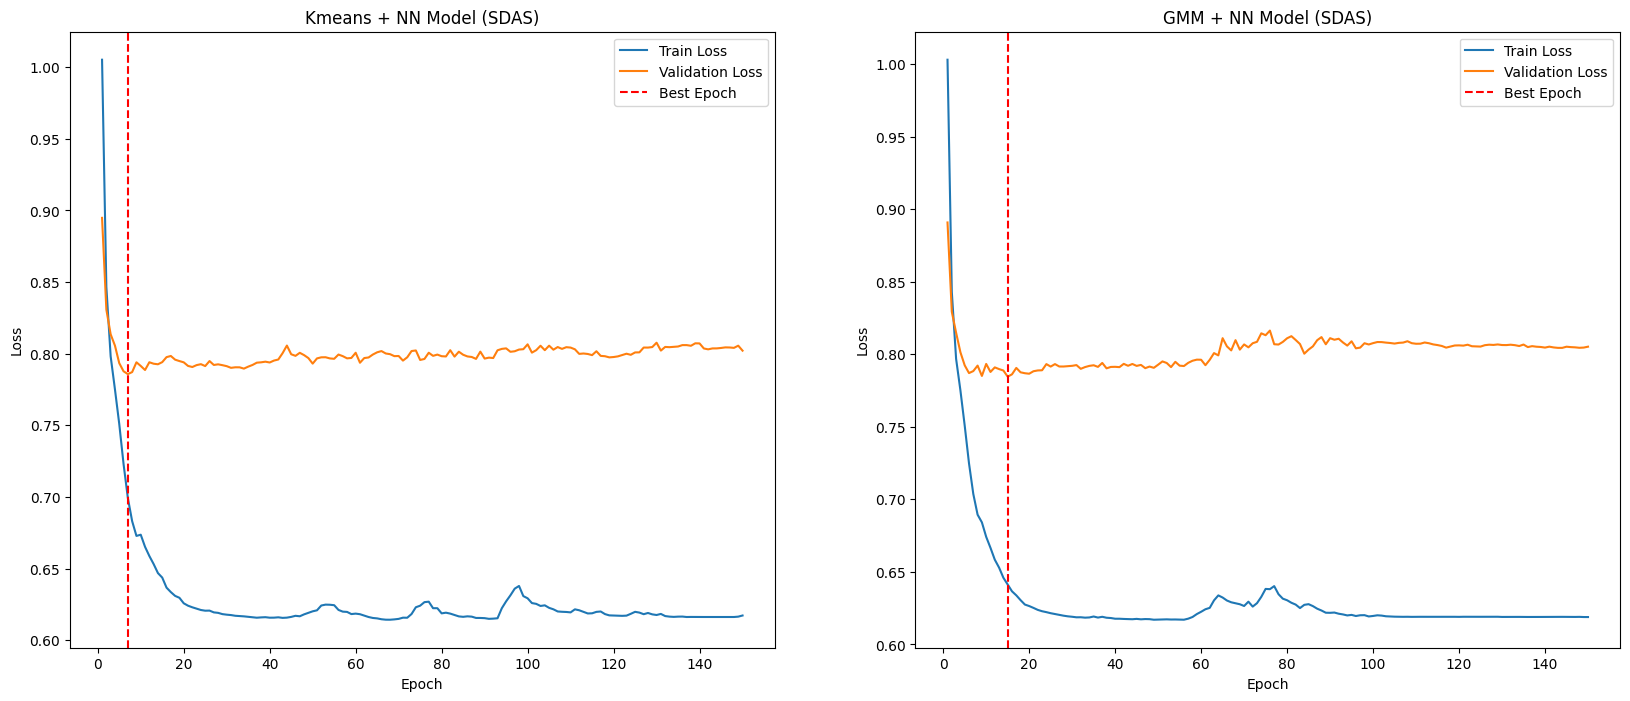

In [48]:
# Plot the loss curves in subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Kmeans subplot
x_range = range(1, len(avg_train_loss_kmeans) + 1)
axs[0].plot(x_range,avg_train_loss_kmeans, label='Train Loss')# thickiness of the line (linewidth=2
axs[0].plot(x_range,avg_val_loss_kmeans, label='Validation Loss')
axs[0].axvline(x=best_epoch_kmeans, color='r', linestyle='--', label='Best Epoch')
axs[0].set_title('Kmeans + NN Model (SDAS)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

x_range = range(1, len(avg_train_loss_gmm) + 1)
# GMM subplot
axs[1].plot(x_range, avg_train_loss_gmm, label='Train Loss')
axs[1].plot(x_range, avg_val_loss_gmm, label='Validation Loss')
axs[1].axvline(x=best_epoch_gmm, color='r', linestyle='--', label='Best Epoch')
axs[1].set_title('GMM + NN Model (SDAS)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()


best_epochs = {
    'KMeans': best_epoch_kmeans,
    'GMM': best_epoch_gmm
}


print(best_epochs, len(avg_train_loss_kmeans))

### reparameterize NN pipeliens with best epoch

In [49]:
reload_notebook_cell()

## raisin Kmeans
best_net_inputs_sdas["module__input_dim"] = 200+2
best_net_inputs_sdas["max_epochs"] = best_epochs['KMeans']
best_net_inputs_sdas["module__output_dim"] = 3
net_kmeans_sdas_pipeline = pipelines.NN_pipeline_with_clustering(X_train_sdas, CATEGORY_COLUMNS_UCML,  best_net_inputs_sdas, best_kmeans_sdas, cluster_method='kmeans')

# raisin GMM
best_net_inputs_sdas["module__input_dim"]=200+5
best_net_inputs_sdas["max_epochs"] = best_epochs['GMM']
best_net_inputs_sdas["module__output_dim"] = 3
net_gmm_sdas_pipeline = pipelines.NN_pipeline_with_clustering(X_train_sdas, CATEGORY_COLUMNS_UCML,  best_net_inputs_sdas, best_gaussian_sdas, cluster_method='gmm')




cpu
cpu


In [50]:
np.unique(y_train_encoded_sdas)

array([0, 1, 2], dtype=int64)

In [51]:

reload_notebook_cell()
from sklearn.preprocessing import OneHotEncoder


# # perform cross validation
scores_kmeans = cross_validate(
    net_kmeans_sdas_pipeline,
    X_train_sdas,
    y_train_encoded_sdas,
    cv=cv,
    return_train_score=True,
    scoring={
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='macro'),
        # 'log_loss': make_scorer(log_loss, **{"labels":[0., 1., 2.]})
    },
    n_jobs=1
)

scores_gmm = cross_validate(
    net_gmm_sdas_pipeline,
    X_train_sdas,
    y_train_encoded_sdas,
    cv=cv,
    return_train_score=True,
    scoring={
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='macro'),
        # 'log_loss': make_scorer(log_loss,  **{"labels":[0, 1, 2]})
    },
    n_jobs=1
)


In [52]:
scores_kmeans["test_log_loss"] = best_val_loss_kmeans
scores_kmeans["train_log_loss"] = avg_train_loss_kmeans[best_epoch_kmeans-1]
scores_gmm["test_log_loss"] = best_val_loss_gmm
scores_gmm["train_log_loss"] = avg_train_loss_gmm[best_epoch_gmm-1]


scores_gmm

{'fit_time': array([1.57717156, 2.34968758, 1.74069834, 2.09767866]),
 'score_time': array([0.04185152, 0.04706812, 0.03264475, 0.04514217]),
 'test_accuracy': array([0.76158192, 0.73220339, 0.73446328, 0.74208145]),
 'train_accuracy': array([0.8749058 , 0.88658628, 0.88847023, 0.8873823 ]),
 'test_f1': array([0.69767669, 0.67343043, 0.67049064, 0.65414079]),
 'train_f1': array([0.83993551, 0.85705224, 0.86320777, 0.8596259 ]),
 'test_log_loss': 0.7845319810616319,
 'train_log_loss': 0.6413617022104573}

In [53]:
import pandas as pd
# Example cross-validation results dictionaries for other methods


# Convert to DataFrames
df_scores_kmeans = pd.DataFrame(scores_kmeans)
df_scores_gmm = pd.DataFrame(scores_gmm)
# Rename columns
df_scores_kmeans.rename(columns={'test_f1': 'validation_f1', 'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_gmm.rename(columns={'test_f1': 'validation_f1', 'test_log_loss': 'validation_log_loss'}, inplace=True)





# Add method names
df_scores_kmeans['method'] = 'KMeans'
df_scores_gmm['method'] = 'GMM'

# Combine all DataFrames
df_all_scores = pd.concat([ df_scores_kmeans, df_scores_gmm], ignore_index=True)
df_avg_scores = df_all_scores.groupby('method').mean().reset_index()
df_avg_scores

,method,fit_time,score_time,test_accuracy,train_accuracy,validation_f1,train_f1,validation_log_loss,train_log_loss
0,GMM,1.941309,0.041677,0.742583,0.884336,0.673935,0.854955,0.784532,0.641362
1,KMeans,0.826306,0.044432,0.747669,0.851088,0.655839,0.799679,0.785730,0.699271


## See How each model performs on the test set

In [54]:
import copy
reload_notebook_cell()
best_net_inputs_sdas["max_epochs"] = best_epoch_kmeans

best_net_inputs_sdas["module__input_dim"] = 202
net_pipeline_kmeans = pipelines.NN_pipeline_with_clustering(X_train_sdas, CATEGORY_COLUMNS_UCML,  best_net_inputs_sdas, best_kmeans_sdas, cluster_method='kmeans')
# adjust for RP
best_net_inputs_sdas  = copy.deepcopy(best_net_inputs_sdas)
best_net_inputs_sdas["module__input_dim"] = 205
best_net_inputs_sdas["max_epochs"] = best_epoch_gmm
net_pipeline_gmm = pipelines.NN_pipeline_with_clustering(X_train_sdas, CATEGORY_COLUMNS_UCML,  best_net_inputs_sdas, best_gaussian_sdas, cluster_method='gmm')



cpu
cpu


In [55]:
reload_notebook_cell()
net_pipeline_kmeans.fit(X_train_sdas, y_train_encoded_sdas)
net_pipeline_gmm.fit(X_train_sdas, y_train_encoded_sdas)


NN(steps=[('preprocessor',
           ColumnTransformer(remainder='passthrough',
                             transformers=[('num', StandardScaler(),
                                            ["encoding__Father's "
                                             'occupation_182',
                                             "encoding__Mother's "
                                             'qualification_39',
                                             "encoding__Father's "
                                             'qualification_34',
                                             "encoding__Mother's "
                                             'qualification_43',
                                             "encoding__Father's "
                                             'occupation_132',
                                             "encoding__Father's "
                                             'occupation_183',
                                             "encoding__Fath...
           <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CustomBackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=205, out_features=80, bias=True)
      (1): Linear(in_features=80, out_features=80, bias=True)
      (2): Linear(in_features=80, out_features=3, bias=True)
    )
  ),
))])

In [56]:
reload_notebook_cell()
## evaluate accuracy and log loss of the models on test 
y_pred_kmeans = net_pipeline_kmeans.predict(X_test_sdas)
y_pred_gmm = net_pipeline_gmm.predict(X_test_sdas)


accuracy_kmeans = f1_score(y_test_encoded_sdas, y_pred_kmeans, average='macro')
accuracy_gmm = f1_score(y_test_encoded_sdas, y_pred_gmm, average='macro')


log_loss_kmeans = log_loss(y_test_encoded_sdas, net_pipeline_kmeans.predict_proba(X_test_sdas))
log_loss_gmm = log_loss(y_test_encoded_sdas, net_pipeline_gmm.predict_proba(X_test_sdas))


print(f'Accuracy Kmeans: {accuracy_kmeans:.4f}, Log Loss Kmeans: {log_loss_kmeans:.4f}')
print(f'Accuracy GMM: {accuracy_gmm:.4f}, Log Loss Gmm: {log_loss_gmm:.4f}')

df_avg_scores['test_f1'] = [accuracy_gmm, accuracy_kmeans]
df_avg_scores['test_log_loss'] = [log_loss_gmm, log_loss_kmeans]
df_avg_scores["best_epoch"] = [best_epoch_gmm, best_epoch_kmeans]

df_avg_scores

Accuracy Kmeans: 0.6358, Log Loss Kmeans: 0.7993
Accuracy GMM: 0.6372, Log Loss Gmm: 0.8031


,method,fit_time,score_time,test_accuracy,train_accuracy,validation_f1,train_f1,validation_log_loss,train_log_loss,test_f1,test_log_loss,best_epoch
0,GMM,1.941309,0.041677,0.742583,0.884336,0.673935,0.854955,0.784532,0.641362,0.637238,0.803130,15
1,KMeans,0.826306,0.044432,0.747669,0.851088,0.655839,0.799679,0.785730,0.699271,0.635773,0.799268,7
